In [1]:
from cc.env.collect import sample_feedforward_and_collect
from cc.env import make_env
from cc import save, load 
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, TrainingOptionsModel, 
    EvaluationMetrices, Tracker, make_dataloader, DictLogger,
    Regularisation
)
import jax.random as jrand
from cc.utils import rmse, l2_norm
import optax
import jax.numpy as jnp

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
sample_train = sample_feedforward_and_collect(
    env,
    seeds_gp=[0,1,2,3,4,5,6,7,8,9,10,11],
    seeds_cos=[1,2,3,4,5,6,7,8,9,10,12,14]
)

sample_val = sample_feedforward_and_collect(
    env, 
    seeds_gp=[15, 16, 17, 18],
    seeds_cos=[2.5, 5.0, 7.5, 10.0]
)

In [4]:
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [5]:
model_train_dataloader = make_dataloader(
    (sample_train.action, sample_train.obs), # <- (X, y)
    jrand.PRNGKey(2,), 
    n_minibatches=4
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-3))

regularisers = (
    Regularisation(
        prefactor = 0.5,
        reduce_weights = lambda vector_of_params: {"l2_norm": l2_norm(vector_of_params)}
    ),
)

metrices = (
    EvaluationMetrices(
        data = (sample_val.action, sample_val.obs), # <- (X, y)
        metrices=(
            lambda y, yhat: {"val_rmse": rmse(y, yhat)}, 
        )
    ),
)

model_train_options = TrainingOptionsModel(
    model_train_dataloader, 
    optimizer, 
    regularisers=(),
    metrices=metrices
)

model_trainer = ModelControllerTrainer(
    model, 
    model_train_options=model_train_options,
    loggers=[DictLogger()],
    trackers=[Tracker("val_rmse")]
)

In [6]:
model_trainer.run(1000)

train_loss:     0.1705 | train_mse:     0.1705 | val_rmse:     0.4656 | : 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


In [7]:
model_trainer.trackers[0].best_metric()

0.3864077

In [8]:
fitted_model = model_trainer.trackers[0].best_model()

# Training a controller

In [42]:
from cc.train import TrainingOptionsController
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect.collect import collect_random_step_source
from cc.env.wrappers import AddRefSignalRewardFnWrapper

source = collect_random_step_source(env, seeds=list(range(30)))
env_w_source = AddRefSignalRewardFnWrapper(env, source)

In [43]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep,
    5,
    f_depth=0
)

In [44]:
controller_dataloader = make_dataloader(
    source.get_references_for_optimisation(),
    jrand.PRNGKey(1,),
    n_minibatches=5
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))

controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, 
)

controller_trainer = ModelControllerTrainer(
    fitted_model, controller, controller_train_options=controller_train_options, 
    trackers=[Tracker("train_mse")]
)

In [45]:
controller_trainer.run(500)

train_loss:     0.6868 | train_mse:     0.6868 | : 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


In [46]:
fitted_controller = controller_trainer.trackers[0].best_model()
controller_trainer.trackers[0].best_metric()

0.68677765

In [58]:
from cc.env.collect import collect_exhaust_source

eval_source = collect_random_step_source(env, seeds=list(range(6)))
controller_performance_sample = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)

Reference Iterator: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


In [59]:
jnp.mean(-controller_performance_sample.rew)

DeviceArray(0.40226033, dtype=float32)

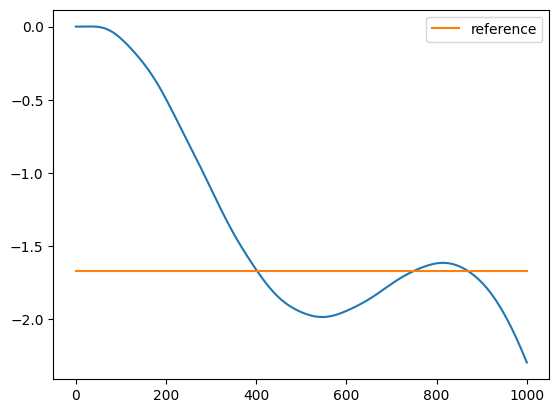

In [61]:
import matplotlib.pyplot as plt 

i = 5
plt.plot(controller_performance_sample.obs["obs"]["xpos_of_segment_end"][i])
plt.plot(controller_performance_sample.obs["ref"]["xpos_of_segment_end"][i], label="reference")
plt.legend()